In [1]:
# 小米SU7微博舆情分析 - 探索性数据分析
# ==========================================

import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', None)

# 数据路径
DATA_PATH = '../小米SU7数据'

# 获取所有日期文件夹
date_folders = sorted([f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))])
print(f"数据覆盖日期范围: {date_folders[0]} 至 {date_folders[-1]}")
print(f"共 {len(date_folders)} 天的数据")

数据覆盖日期范围: 2025-03-27 至 2025-04-14
共 19 天的数据


In [2]:
# 1. 加载并合并所有数据
# ========================

def load_all_data(data_path, date_folders):
    """加载所有日期的数据"""
    all_weibo = []
    all_comments = []
    all_forwards = []
    all_comment_chains = []
    
    for date_folder in date_folders:
        folder_path = os.path.join(data_path, date_folder)
        
        # 热门微博
        weibo_file = os.path.join(folder_path, '热门微博.csv')
        if os.path.exists(weibo_file):
            df = pd.read_csv(weibo_file)
            df['crawl_date'] = date_folder
            all_weibo.append(df)
        
        # 评论数据
        comment_file = os.path.join(folder_path, '热门微博评论数据.csv')
        if os.path.exists(comment_file):
            df = pd.read_csv(comment_file)
            df['crawl_date'] = date_folder
            all_comments.append(df)
        
        # 转发数据
        forward_file = os.path.join(folder_path, '热门微博转发数据.csv')
        if os.path.exists(forward_file):
            df = pd.read_csv(forward_file)
            df['crawl_date'] = date_folder
            all_forwards.append(df)
        
        # 评论链结构(带打分)
        chain_file = os.path.join(folder_path, '评论链结构_打分.csv')
        if os.path.exists(chain_file):
            df = pd.read_csv(chain_file, encoding='utf-8-sig')
            df['crawl_date'] = date_folder
            all_comment_chains.append(df)
    
    weibo_df = pd.concat(all_weibo, ignore_index=True) if all_weibo else pd.DataFrame()
    comments_df = pd.concat(all_comments, ignore_index=True) if all_comments else pd.DataFrame()
    forwards_df = pd.concat(all_forwards, ignore_index=True) if all_forwards else pd.DataFrame()
    chains_df = pd.concat(all_comment_chains, ignore_index=True) if all_comment_chains else pd.DataFrame()
    
    return weibo_df, comments_df, forwards_df, chains_df

weibo_df, comments_df, forwards_df, chains_df = load_all_data(DATA_PATH, date_folders)

print("=" * 60)
print("数据集加载完成:")
print(f"  热门微博: {len(weibo_df):,} 条")
print(f"  评论数据: {len(comments_df):,} 条")
print(f"  转发数据: {len(forwards_df):,} 条")
print(f"  评论链(带立场得分): {len(chains_df):,} 条")
print("=" * 60)

数据集加载完成:
  热门微博: 7,215 条
  评论数据: 273,975 条
  转发数据: 26,358 条
  评论链(带立场得分): 273,760 条


In [3]:
# 2. 查看各数据集的结构
# ========================

print("=" * 60)
print("【热门微博数据结构】")
print("=" * 60)
print(f"字段: {list(weibo_df.columns)}")
print(f"\n数据类型:")
print(weibo_df.dtypes)
print(f"\n前3条数据:")
weibo_df.head(3)

【热门微博数据结构】
字段: ['author_name', 'author_url', 'weibo_url', 'publish_time', 'weibo_content', 'repost_count', 'comment_count', 'like_count', 'crawl_date']

数据类型:
author_name      object
author_url       object
weibo_url        object
publish_time     object
weibo_content    object
repost_count      int64
comment_count     int64
like_count        int64
crawl_date       object
dtype: object

前3条数据:


,author_name,author_url,weibo_url,publish_time,weibo_content,repost_count,comment_count,like_count,crawl_date
0,小米汽车,https://weibo.com/7871239944,https://weibo.com/7871239944/PkvsRdOvf,2025-03-27 18:22:00,众所周知，小米汽车的广告都是车主拍的👏 一起来欣赏大片，小米SU7 Ultra车主出品。 L小米汽车的微博视频,48,105,0,2025-03-27
1,YTB亮眼,https://weibo.com/7747056179,https://weibo.com/7747056179/Pkpf5e7ul,2025-03-27 02:32:00,小米su7是他的命吧，有同款队友吗 LYTB亮眼的微博视频,30,280,0,2025-03-27
2,交通安全蜀黍,https://weibo.com/1653076903,https://weibo.com/1653076903/PkrMwbgDE,2025-03-27 09:00:00,网友爆料：小米SU7车主提新车光顾着拍视频，眼看着撞上去也没有接管车辆…… #蜀黍说安全##小米su7# L交通安全蜀黍的微博视频,42,463,0,2025-03-27


In [4]:
print("=" * 60)
print("【评论数据结构】")
print("=" * 60)
print(f"字段: {list(comments_df.columns)}")
print(f"\n数据类型:")
print(comments_df.dtypes)
print(f"\n前3条数据:")
comments_df.head(3)

【评论数据结构】
字段: ['原文链接', '根评论ID', '父评论ID', '评论ID', '用户ID', '父用户昵称', '用户昵称', '评论内容', '发布时间', '子评论数', '点赞数', '用户认证', '用户总评论数', '用户总转发数', '用户总点赞数', '是否是一级评论', 'crawl_date']

数据类型:
原文链接           object
根评论ID         float64
父评论ID           int64
评论ID            int64
用户ID            int64
父用户昵称          object
用户昵称           object
评论内容           object
发布时间           object
子评论数            int64
点赞数             int64
用户认证             bool
用户总评论数         object
用户总转发数         object
用户总点赞数         object
是否是一级评论          bool
crawl_date     object
dtype: object

前3条数据:


,原文链接,根评论ID,父评论ID,评论ID,用户ID,父用户昵称,用户昵称,评论内容,发布时间,子评论数,点赞数,用户认证,用户总评论数,用户总转发数,用户总点赞数,是否是一级评论,crawl_date
0,https://weibo.com/7871239944/PkvsRdOvf,NaN,7871239944,5148876097454178,6865028041,NaN,挖土的小铜钱,非常好非常好，好产品应当像小米汽车一样会自动宣传[鼓掌][鼓掌][鼓掌][打call][打call][打call],2025-03-27 18:26:25,3,0,True,25928,610,40859,True,2025-03-27
1,https://weibo.com/7871239944/PkvsRdOvf,5.148876e+15,5148876097454178,5149071107164278,7883462042,挖土的小铜钱,北北极_,对对对啊,2025-03-28 07:21:20,0,0,False,28,19,35,False,2025-03-27
2,https://weibo.com/7871239944/PkvsRdOvf,5.148876e+15,5148876625937243,5148876723719001,6865028041,小米汽车,挖土的小铜钱,加油加油加油,2025-03-27 18:28:55,0,0,True,"25,928",610,"40,859",False,2025-03-27


In [5]:
print("=" * 60)
print("【评论链结构(带立场得分)数据结构】")
print("=" * 60)
print(f"字段: {list(chains_df.columns)}")
print(f"\n数据类型:")
print(chains_df.dtypes)
print(f"\n前5条数据:")
chains_df.head(5)

【评论链结构(带立场得分)数据结构】
字段: ['weibo_id', 'thread_id', 'time_id', 'comment_index', 'comment_user', 'replied_to_user', 'thread_text', '立场得分', '是否相关', 'crawl_date']

数据类型:
weibo_id             int64
thread_id            int64
time_id              int64
comment_index        int64
comment_user        object
replied_to_user     object
thread_text         object
立场得分               float64
是否相关               float64
crawl_date          object
dtype: object

前5条数据:


,weibo_id,thread_id,time_id,comment_index,comment_user,replied_to_user,thread_text,立场得分,是否相关,crawl_date
0,82,1,0,4868,煮不熟的茶叶蛋-,主题,SU7大卖，Higo比死了爹还难受,0.854,1.0,2025-03-27
1,82,1,1,4869,俺彩色的很,煮不熟的茶叶蛋-,海狗会说：全是假的 销量造假 查看图片,-0.732,1.0,2025-03-27
2,36,2,0,2688,跨域星推官,主题,欢迎加入微博跨域计划，跨领域内容添加#微博跨域计划# 话题词，有机会获得曝光资源及行业合作机会！了解更多戳>>http://t.cn/A6HpCqzk,0.000,0.0,2025-03-27
3,36,3,0,2687,小迪爱吃巧克力-,主题,哇 还得是小米,0.643,1.0,2025-03-27
4,36,4,0,2675,北眠想吃杯面,主题,这样就不会获得要付钱的人生照片了,0.000,0.0,2025-03-27


In [3]:
# 3. 数据清洗
# ========================

# 3.1 去除重复数据
print("【数据去重】")
print(f"去重前 - 微博: {len(weibo_df)}, 评论: {len(comments_df)}, 评论链: {len(chains_df)}")

# 微博根据URL去重
weibo_df_clean = weibo_df.drop_duplicates(subset=['weibo_url'], keep='last')

# 评论根据评论ID去重
comments_df_clean = comments_df.drop_duplicates(subset=['评论ID'], keep='last')

# 评论链根据 weibo_id, thread_id, time_id 去重
chains_df_clean = chains_df.drop_duplicates(subset=['weibo_id', 'thread_id', 'time_id'], keep='last')

print(f"去重后 - 微博: {len(weibo_df_clean)}, 评论: {len(comments_df_clean)}, 评论链: {len(chains_df_clean)}")

# 3.2 处理缺失值
print("\n【缺失值情况】")
print("评论数据缺失值统计:")
print(comments_df_clean.isnull().sum())

【数据去重】
去重前 - 微博: 7215, 评论: 273975, 评论链: 273760
去重后 - 微博: 4153, 评论: 273937, 评论链: 272518

【缺失值情况】
评论数据缺失值统计:
原文链接               0
根评论ID         156171
父评论ID              0
评论ID               0
用户ID               0
父用户昵称         156171
用户昵称               0
评论内容            2485
发布时间               0
子评论数               0
点赞数                0
用户认证               0
用户总评论数             0
用户总转发数             0
用户总点赞数             0
是否是一级评论            0
crawl_date         0
dtype: int64


In [4]:
# 3.3 数据类型转换与清洗
print("【数据类型转换】")

# 转换时间字段
weibo_df_clean['publish_time'] = pd.to_datetime(weibo_df_clean['publish_time'])
comments_df_clean['发布时间'] = pd.to_datetime(comments_df_clean['发布时间'])

# 处理用户统计数据中的逗号(如 "25,928" -> 25928)
def clean_number(x):
    if isinstance(x, str):
        return int(x.replace(',', ''))
    return x

comments_df_clean['用户总评论数'] = comments_df_clean['用户总评论数'].apply(clean_number)
comments_df_clean['用户总转发数'] = comments_df_clean['用户总转发数'].apply(clean_number)
comments_df_clean['用户总点赞数'] = comments_df_clean['用户总点赞数'].apply(clean_number)

# 填充空评论内容
comments_df_clean['评论内容'] = comments_df_clean['评论内容'].fillna('')

print("时间字段和数值字段转换完成")
print(f"\n微博时间范围: {weibo_df_clean['publish_time'].min()} 至 {weibo_df_clean['publish_time'].max()}")
print(f"评论时间范围: {comments_df_clean['发布时间'].min()} 至 {comments_df_clean['发布时间'].max()}")

【数据类型转换】


时间字段和数值字段转换完成

微博时间范围: 2025-03-27 00:13:00 至 2025-04-14 22:59:00
评论时间范围: 2025-03-27 00:22:01 至 2025-07-07 07:34:23


In [8]:
# 4. 基础统计分析
# ========================
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("【基础统计信息】")
print("=" * 60)

# 4.1 微博统计
print("\n--- 热门微博统计 ---")
print(f"独立微博数: {weibo_df_clean['weibo_url'].nunique()}")
print(f"独立作者数: {weibo_df_clean['author_name'].nunique()}")
print(f"平均转发数: {weibo_df_clean['repost_count'].mean():.1f}")
print(f"平均评论数: {weibo_df_clean['comment_count'].mean():.1f}")
print(f"平均点赞数: {weibo_df_clean['like_count'].mean():.1f}")

# 4.2 评论统计
print("\n--- 评论数据统计 ---")
print(f"总评论数: {len(comments_df_clean):,}")
print(f"一级评论数: {comments_df_clean['是否是一级评论'].sum():,}")
print(f"回复评论数: {(~comments_df_clean['是否是一级评论']).sum():,}")
print(f"独立用户数: {comments_df_clean['用户ID'].nunique():,}")
print(f"认证用户评论数: {comments_df_clean['用户认证'].sum():,}")

# 4.3 点赞分布
print("\n--- 评论点赞分布 ---")
print(comments_df_clean['点赞数'].describe())

【基础统计信息】

--- 热门微博统计 ---
独立微博数: 4153
独立作者数: 1664
平均转发数: 21.8
平均评论数: 111.0
平均点赞数: 0.0

--- 评论数据统计 ---
总评论数: 273,937
一级评论数: 156,171
回复评论数: 117,766
独立用户数: 106,951
认证用户评论数: 35,359

--- 评论点赞分布 ---
count    273937.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: 点赞数, dtype: float64


In [9]:
# 4.4 立场得分分析（评论链数据）
print("=" * 60)
print("【立场得分分析】")
print("=" * 60)

# 只看相关评论
related_chains = chains_df_clean[chains_df_clean['是否相关'] == 1]
print(f"\n相关评论数: {len(related_chains):,} (占比: {len(related_chains)/len(chains_df_clean)*100:.1f}%)")
print(f"非相关评论数: {len(chains_df_clean) - len(related_chains):,}")

print("\n--- 立场得分分布(相关评论) ---")
print(related_chains['立场得分'].describe())

# 情感分类
def classify_sentiment(score):
    if score > 0.3:
        return '正面'
    elif score < -0.3:
        return '负面'
    else:
        return '中性'

related_chains['情感分类'] = related_chains['立场得分'].apply(classify_sentiment)
sentiment_dist = related_chains['情感分类'].value_counts()
print("\n--- 情感分类分布 ---")
print(sentiment_dist)
print(f"\n正面占比: {sentiment_dist.get('正面', 0)/len(related_chains)*100:.1f}%")
print(f"负面占比: {sentiment_dist.get('负面', 0)/len(related_chains)*100:.1f}%")
print(f"中性占比: {sentiment_dist.get('中性', 0)/len(related_chains)*100:.1f}%")

【立场得分分析】

相关评论数: 202,934 (占比: 74.5%)
非相关评论数: 69,584

--- 立场得分分布(相关评论) ---
count    202934.000000
mean         -0.190926
std           0.481105
min          -1.000000
25%          -0.567000
50%          -0.234000
75%           0.123000
max           1.000000
Name: 立场得分, dtype: float64

--- 情感分类分布 ---
情感分类
负面    94573
中性    72198
正面    36163
Name: count, dtype: int64

正面占比: 17.8%
负面占比: 46.6%
中性占比: 35.6%


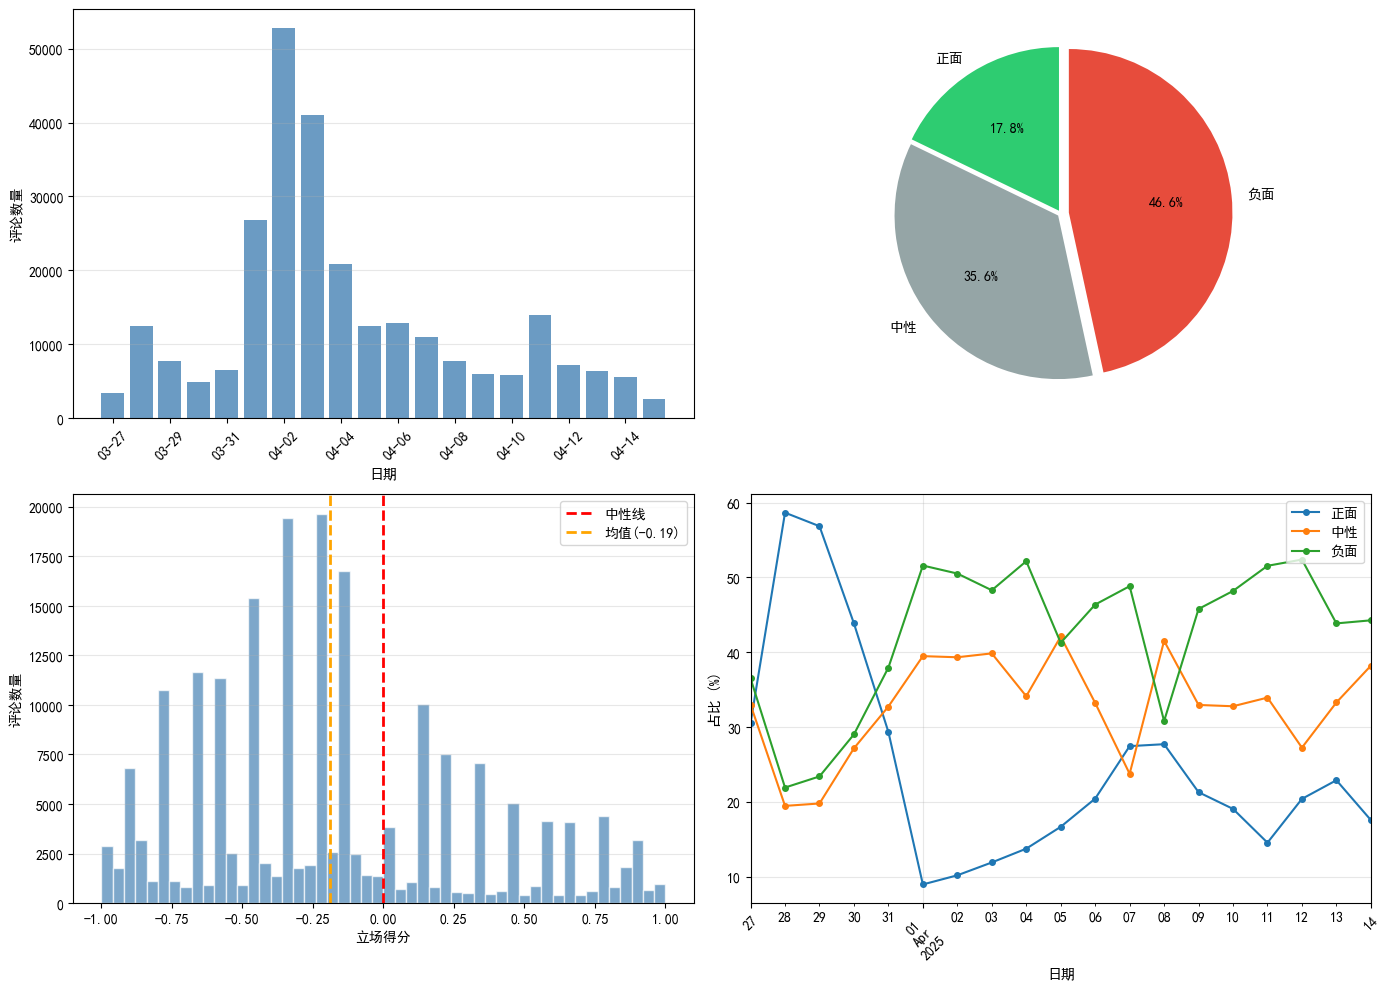

图表已保存至 results/eda_overview.png


In [10]:
# 5. 可视化分析
# ========================
import matplotlib.pyplot as plt
import os

# 创建results文件夹
os.makedirs('../results', exist_ok=True)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 5.1 每日评论数量趋势
comments_df_clean['发布日期'] = comments_df_clean['发布时间'].dt.date
daily_comments = comments_df_clean.groupby('发布日期').size()
# 只取主要时间段
daily_comments = daily_comments[daily_comments.index <= pd.to_datetime('2025-04-15').date()]

axes[0, 0].bar(range(len(daily_comments)), daily_comments.values, color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('日期')
axes[0, 0].set_ylabel('评论数量')
axes[0, 0].set_xticks(range(0, len(daily_comments), 2))
axes[0, 0].set_xticklabels([str(d)[5:] for d in daily_comments.index[::2]], rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 5.2 情感分布饼图
colors = ['#2ecc71', '#95a5a6', '#e74c3c']
sentiment_dist = related_chains['情感分类'].value_counts()
sentiment_counts = [sentiment_dist.get('正面', 0), sentiment_dist.get('中性', 0), sentiment_dist.get('负面', 0)]
axes[0, 1].pie(sentiment_counts, labels=['正面', '中性', '负面'], colors=colors, 
               autopct='%1.1f%%', startangle=90, explode=(0.02, 0.02, 0.05))

# 5.3 立场得分分布直方图
axes[1, 0].hist(related_chains['立场得分'], bins=50, color='steelblue', alpha=0.7, edgecolor='white')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='中性线')
axes[1, 0].axvline(x=related_chains['立场得分'].mean(), color='orange', linestyle='--', 
                   linewidth=2, label=f'均值({related_chains["立场得分"].mean():.2f})')
axes[1, 0].set_xlabel('立场得分')
axes[1, 0].set_ylabel('评论数量')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 5.4 每日情感趋势
related_chains['爬取日期'] = pd.to_datetime(related_chains['crawl_date'])
daily_sentiment = related_chains.groupby(['爬取日期', '情感分类']).size().unstack(fill_value=0)
if not daily_sentiment.empty:
    daily_sentiment_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0) * 100
    daily_sentiment_pct[['正面', '中性', '负面']].plot(ax=axes[1, 1], marker='o', markersize=4)
    axes[1, 1].set_xlabel('日期')
    axes[1, 1].set_ylabel('占比 (%)')
    axes[1, 1].legend(loc='upper right')
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("图表已保存至 results/eda_overview.png")

In [5]:
# 6. 文本预处理与分词
# ========================
import jieba
import jieba.analyse
import re
from collections import Counter

print("【文本预处理】")

# 6.1 文本清洗函数
def clean_text(text):
    """清洗微博文本"""
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # 移除@用户
    text = re.sub(r'@[\w\u4e00-\u9fff]+[:\s]?', '', text)
    
    # 移除话题标签内容但保留话题文字
    text = re.sub(r'#([^#]+)#', r'\1', text)
    
    # 移除URL
    text = re.sub(r'http[s]?://\S+', '', text)
    
    # 移除表情符号标记 [xxx]
    text = re.sub(r'\[[\w\u4e00-\u9fff]+\]', '', text)
    
    # 移除特殊字符，保留中文、英文、数字
    text = re.sub(r'[^\u4e00-\u9fff\w\s]', ' ', text)
    
    # 合并多余空格
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 测试清洗函数
test_text = "回复@某用户:小米SU7真的太棒了！#小米汽车# [赞][赞] http://t.cn/xxx"
print(f"原文: {test_text}")
print(f"清洗后: {clean_text(test_text)}")

【文本预处理】
原文: 回复@某用户:小米SU7真的太棒了！#小米汽车# [赞][赞] http://t.cn/xxx
清洗后: 回复小米SU7真的太棒了 小米汽车


In [6]:
# 6.2 应用文本清洗
print("正在清洗评论文本...")
comments_df_clean['评论内容_清洗'] = comments_df_clean['评论内容'].apply(clean_text)

# 同时清洗评论链数据
chains_df_clean['thread_text_清洗'] = chains_df_clean['thread_text'].apply(clean_text)

print(f"评论清洗完成: {len(comments_df_clean)} 条")
print(f"评论链清洗完成: {len(chains_df_clean)} 条")

# 查看清洗效果
print("\n--- 清洗前后对比 ---")
sample_idx = comments_df_clean[comments_df_clean['评论内容'].str.len() > 20].index[:3]
for idx in sample_idx:
    print(f"原文: {comments_df_clean.loc[idx, '评论内容'][:80]}...")
    print(f"清洗: {comments_df_clean.loc[idx, '评论内容_清洗'][:80]}...")
    print()

正在清洗评论文本...


评论清洗完成: 273937 条
评论链清洗完成: 272518 条

--- 清洗前后对比 ---
原文: 非常好非常好，好产品应当像小米汽车一样会自动宣传[鼓掌][鼓掌][鼓掌][打call][打call][打call]...
清洗: 非常好非常好 好产品应当像小米汽车一样会自动宣传...

原文: 拍一个[春游家族] http://t.cn/A6BDiTlH...
清洗: 拍一个...

原文: 小米车主太有才了！ 因为SU7, 我也认识了许多新朋友[坏笑]...
清洗: 小米车主太有才了 因为SU7 我也认识了许多新朋友...



In [7]:
# 6.3 中文分词
print("【中文分词】")

# 添加小米汽车相关词汇到词典
custom_words = [
    '小米汽车', '小米SU7', 'SU7', '雷军', '保时捷', 'Taycan', 
    '智能驾驶', '自动驾驶', '辅助驾驶', '智驾', 
    '续航', '电池', '充电', '快充', '超充',
    '智能座舱', '车机', '大屏', '澎湃OS',
    '性价比', '质价比', '定价', '预售',
    '交付', '锁单', '大定', '小定',
    '比亚迪', '特斯拉', 'Model3', '蔚来', '小鹏', '理想', '问界', '华为',
    '遥遥领先', '真香', '割韭菜', '智商税'
]

for word in custom_words:
    jieba.add_word(word)

# 加载停用词
stopwords = set([
    '的', '了', '是', '在', '我', '有', '和', '就', '不', '人', '都', '一', '一个',
    '上', '也', '很', '到', '说', '要', '去', '你', '会', '着', '没有', '看', '好',
    '自己', '这', '那', '他', '她', '它', '们', '这个', '那个', '什么', '怎么',
    '为什么', '哪', '哪里', '哪个', '如何', '但', '但是', '而', '而且', '或', '或者',
    '所以', '因为', '如果', '虽然', '可以', '可能', '应该', '能', '能够', '还',
    '还是', '只', '只是', '只有', '就是', '不是', '没', '吗', '呢', '吧', '啊',
    '哦', '嗯', '呀', '哈', '嘿', '哎', '唉', '真的', '真是', '太', '非常', '很多',
    '一些', '这些', '那些', '这样', '那样', '怎样', '多少', '几', '第', '让', '被',
    '把', '跟', '比', '对', '从', '向', '给', '与', '及', '等', '等等', '之',
    '回复', '转发', '微博', '评论', '用户', '楼主', '楼', '层'
])

def tokenize(text):
    """分词并去停用词"""
    if not text or text == '':
        return []
    words = jieba.lcut(text)
    # 过滤停用词和单字符
    words = [w for w in words if w not in stopwords and len(w) > 1 and not w.isdigit()]
    return words

# 对评论进行分词
print("正在进行分词...")
comments_df_clean['分词结果'] = comments_df_clean['评论内容_清洗'].apply(tokenize)
chains_df_clean['分词结果'] = chains_df_clean['thread_text_清洗'].apply(tokenize)

print(f"分词完成!")

# 查看分词效果
print("\n--- 分词示例 ---")
sample_texts = comments_df_clean[comments_df_clean['分词结果'].apply(len) > 3].head(5)
for idx, row in sample_texts.iterrows():
    print(f"原文: {row['评论内容_清洗'][:60]}...")
    print(f"分词: {row['分词结果'][:10]}")
    print()

Building prefix dict from the default dictionary ...


【中文分词】


Dumping model to file cache C:\Users\LJK\AppData\Local\Temp\jieba.cache


Loading model cost 0.503 seconds.


Prefix dict has been built successfully.


正在进行分词...


分词完成!

--- 分词示例 ---
原文: 非常好非常好 好产品应当像小米汽车一样会自动宣传...
分词: ['产品', '应当', '小米汽车', '一样', '自动', '宣传']

原文: 还有很多 建议继续更新...
分词: ['还有', '建议', '继续', '更新']

原文: 小米车主太有才了 因为SU7 我也认识了许多新朋友...
分词: ['小米', '车主', '太有', 'SU7', '认识', '许多', '朋友']

原文: 太帅了 建议把这位车主也加进去...
分词: ['太帅', '建议', '这位', '车主', '加进去']

原文: 感谢官方和雷总认可 Ultra Ultra 无限可能...
分词: ['感谢', '官方', '认可', 'Ultra', 'Ultra', '无限']



In [14]:
# 6.4 词频统计
print("【词频统计】")

# 汇总所有词
all_words = []
for words in comments_df_clean['分词结果']:
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"总词数: {len(all_words):,}")
print(f"不重复词数: {len(word_freq):,}")

print("\n--- TOP 30 高频词 ---")
top_words = word_freq.most_common(30)
for i, (word, freq) in enumerate(top_words, 1):
    print(f"{i:2}. {word}: {freq:,}")

【词频统计】
总词数: 1,728,196
不重复词数: 77,505

--- TOP 30 高频词 ---
 1. 小米: 32,694
 2. 智驾: 17,536
 3. 问题: 12,216
 4. 事故: 10,629
 5. 知道: 8,500
 6. 这么: 7,859
 7. 车主: 7,777
 8. 现在: 7,532
 9. 开车: 6,805
10. 不能: 6,690
11. 高速: 6,236
12. 安全: 6,222
13. 这种: 6,126
14. 不会: 6,097
15. 出来: 5,688
16. 确实: 5,419
17. 驾驶: 5,365
18. 家属: 5,157
19. 车企: 5,139
20. 速度: 4,902
21. 华为: 4,812
22. 时候: 4,749
23. 电池: 4,706
24. 辅助驾驶: 4,603
25. 责任: 4,546
26. 方向盘: 4,438
27. 驾驶员: 4,397
28. 一样: 4,278
29. 图片: 4,236
30. 司机: 4,211


In [17]:
# 7. 词云生成
# ========================
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("【生成词云】")

# 准备词频字典
word_freq_dict = dict(word_freq.most_common(500))

# 生成词云
# 尝试使用系统中文字体
font_paths = [
    'C:/Windows/Fonts/simhei.ttf',
    'C:/Windows/Fonts/msyh.ttc',
    'C:/Windows/Fonts/simsun.ttc'
]

font_path = None
for fp in font_paths:
    if os.path.exists(fp):
        font_path = fp
        break

if font_path:
    print(f"使用字体: {font_path}")
else:
    print("警告: 未找到中文字体，词云可能显示为方块")

# 创建词云
wc = WordCloud(
    font_path=font_path,
    width=1200,
    height=800,
    background_color='white',
    max_words=100,
    max_font_size=150,
    min_font_size=10,
    colormap='viridis',
    random_state=42
)

wc.generate_from_frequencies(word_freq_dict)

# 绘制词云并保存（不显示以避免输出过大）
fig, ax = plt.subplots(figsize=(16, 10))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
plt.tight_layout()
plt.savefig('../results/wordcloud_all.png', dpi=200, bbox_inches='tight')
plt.close()  # 关闭图形，不显示
print("词云已保存至 results/wordcloud_all.png")

【生成词云】
使用字体: C:/Windows/Fonts/simhei.ttf
词云已保存至 results/wordcloud_all.png


In [10]:
# 8. LDA主题建模
# ========================
from gensim import corpora
from gensim.models import LdaModel
import psutil
import gc

print("【LDA主题建模】")

# 内存监控函数
def check_memory(threshold_percent=90):
    """检查内存使用率，超过阈值则返回False"""
    mem = psutil.virtual_memory()
    used_percent = mem.percent
    print(f"当前内存使用: {used_percent:.1f}% ({mem.used/1024**3:.1f}GB / {mem.total/1024**3:.1f}GB)")
    return used_percent < threshold_percent

# 先进行垃圾回收释放内存
gc.collect()
check_memory()

# 准备语料库 - 使用评论链数据（有立场得分标注的相关评论）
related_mask = chains_df_clean['是否相关'] == 1
related_texts = chains_df_clean.loc[related_mask, '分词结果'].dropna()

# 过滤空列表
all_texts = [t for t in related_texts if len(t) >= 3]
print(f"相关评论总数: {len(all_texts):,}")

# 采样以减少内存占用 - 随机抽取15000条（进一步减少）
import random
random.seed(42)
sample_size = min(15000, len(all_texts))
texts = random.sample(all_texts, sample_size)
print(f"采样后用于主题建模的文档数: {len(texts):,}")

# 清理不需要的变量
del all_texts, related_texts
gc.collect()

# 检查内存
if not check_memory(90):
    raise MemoryError("内存使用率过高，请释放内存后重试")

# 创建词典
dictionary = corpora.Dictionary(texts)

# 更严格地过滤词频，减少词典大小
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=1500)
print(f"词典大小: {len(dictionary)}")

# 创建词袋模型
corpus = [dictionary.doc2bow(text) for text in texts]
print(f"语料库大小: {len(corpus)}")

gc.collect()
check_memory()

【LDA主题建模】
当前内存使用: 76.9% (24.0GB / 31.2GB)


相关评论总数: 146,966
采样后用于主题建模的文档数: 15,000


当前内存使用: 76.8% (24.0GB / 31.2GB)
词典大小: 1500
语料库大小: 15000


当前内存使用: 76.5% (23.9GB / 31.2GB)


True

In [11]:
# 8.2 训练LDA模型（内存优化版）
import gc
gc.collect()

print("正在训练LDA模型...")

# 训练前检查内存
if not check_memory(90):
    raise MemoryError("内存不足，无法开始训练LDA模型")

# 设置主题数
num_topics = 6

# 训练LDA模型 - 使用更保守的参数
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=3,           # 减少迭代次数
    alpha='symmetric',  # 使用对称alpha，减少计算
    eta='symmetric',    # 使用对称eta
    chunksize=500,      # 减小批次大小
    iterations=30,      # 限制每个文档的迭代次数
    eval_every=None,    # 不在训练中评估，节省内存
    minimum_probability=0.01
)

print(f"LDA模型训练完成! 主题数: {num_topics}")

# 训练后检查内存
check_memory()

# 显示各主题的关键词
print("\n" + "=" * 60)
print("【主题关键词】")
print("=" * 60)
for idx, topic in lda_model.print_topics(num_words=10):
    # 解析主题词
    words = []
    for item in topic.split(' + '):
        weight, word = item.split('*')
        word = word.strip().strip('"')
        words.append(f"{word}({float(weight):.3f})")
    print(f"\n主题 {idx + 1}: {', '.join(words)}")

正在训练LDA模型...
当前内存使用: 77.1% (24.1GB / 31.2GB)


LDA模型训练完成! 主题数: 6
当前内存使用: 77.2% (24.1GB / 31.2GB)

【主题关键词】

主题 1: 速度(0.032), 电池(0.019), 电车(0.015), 油车(0.014), 碰撞(0.014), 不行(0.014), 起火(0.013), 刹车(0.013), 小米(0.013), 问题(0.012)

主题 2: 华为(0.032), 车祸(0.024), 确实(0.023), 出来(0.023), 人家(0.022), 小米(0.022), 别人(0.019), 米粉(0.018), 你们(0.017), 知道(0.015)

主题 3: 那么(0.029), 不要(0.025), 直接(0.024), 一下(0.022), 这么(0.020), 为啥(0.013), 出事(0.012), 理解(0.012), 标准版(0.012), 其实(0.011)

主题 4: 小米(0.118), 家属(0.025), 事故(0.023), 雷军(0.016), 联系(0.014), 现在(0.014), 流量(0.013), 出来(0.013), 他们(0.012), su7(0.012)

主题 5: 车门(0.029), 知道(0.025), 打不开(0.021), 开车(0.021), 手机(0.019), 汽车(0.019), 图片(0.018), 造谣(0.017), 相信(0.016), 打开(0.015)

主题 6: 智驾(0.046), 问题(0.025), 车主(0.024), 驾驶(0.022), 安全(0.021), 高速(0.018), 辅助驾驶(0.018), 责任(0.016), 司机(0.016), 不能(0.016)


In [12]:
# 8.3 主题分布可视化
import matplotlib.pyplot as plt
import numpy as np

print("【主题分布可视化】")

# 获取每个主题的关键词用于标签
topic_labels = []
for idx in range(num_topics):
    top_words = lda_model.show_topic(idx, topn=3)
    label = f"主题{idx+1}: " + "/".join([w for w, _ in top_words])
    topic_labels.append(label)

# 统计文档的主题分布
topic_counts = np.zeros(num_topics)
for doc_bow in corpus:
    topic_dist = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    topic_counts[dominant_topic] += 1

# 绘制主题分布柱状图
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(num_topics), topic_counts, color=plt.cm.viridis(np.linspace(0.2, 0.8, num_topics)))
ax.set_xticks(range(num_topics))
ax.set_xticklabels([f'主题{i+1}' for i in range(num_topics)], fontsize=10)
ax.set_ylabel('文档数量', fontsize=12)
ax.set_xlabel('主题', fontsize=12)

# 添加数值标签
for bar, count in zip(bars, topic_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{int(count)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/lda_topic_distribution.png', dpi=200, bbox_inches='tight')
plt.close()
print("主题分布图已保存至 results/lda_topic_distribution.png")

# 打印主题分布统计
print("\n--- 主题分布统计 ---")
for i, (label, count) in enumerate(zip(topic_labels, topic_counts)):
    print(f"{label}: {int(count)} ({count/len(corpus)*100:.1f}%)")

【主题分布可视化】


主题分布图已保存至 results/lda_topic_distribution.png

--- 主题分布统计 ---
主题1: 速度/电池/电车: 2754 (18.4%)
主题2: 华为/车祸/确实: 2359 (15.7%)
主题3: 那么/不要/直接: 1462 (9.7%)
主题4: 小米/家属/事故: 3065 (20.4%)
主题5: 车门/知道/打不开: 1744 (11.6%)
主题6: 智驾/问题/车主: 3616 (24.1%)


In [15]:
# 9. 保存处理后的数据
# ========================
print("【保存处理后的数据】")

# 保存词频统计结果
word_freq_df = pd.DataFrame(word_freq.most_common(500), columns=['词语', '频次'])
word_freq_df.to_csv('../results/word_frequency_top500.csv', index=False, encoding='utf-8-sig')
print(f"词频统计已保存: results/word_frequency_top500.csv")

# 保存LDA主题结果
topic_results = []
for idx in range(num_topics):
    topic_words = lda_model.show_topic(idx, topn=20)
    for word, weight in topic_words:
        topic_results.append({
            '主题编号': idx + 1,
            '词语': word,
            '权重': round(weight, 4)
        })

topic_df = pd.DataFrame(topic_results)
topic_df.to_csv('../results/lda_topics.csv', index=False, encoding='utf-8-sig')
print(f"LDA主题结果已保存: results/lda_topics.csv")

# 保存主题分布统计
topic_dist_df = pd.DataFrame({
    '主题编号': range(1, num_topics + 1),
    '主题关键词': topic_labels,
    '文档数量': topic_counts.astype(int),
    '占比': [f'{c/len(corpus)*100:.1f}%' for c in topic_counts]
})
topic_dist_df.to_csv('../results/lda_topic_distribution.csv', index=False, encoding='utf-8-sig')
print(f"主题分布统计已保存: results/lda_topic_distribution.csv")

print("\n所有结果已保存完成!")

【保存处理后的数据】
词频统计已保存: results/word_frequency_top500.csv
LDA主题结果已保存: results/lda_topics.csv
主题分布统计已保存: results/lda_topic_distribution.csv

所有结果已保存完成!
